### LangGraph Chatbot

In [12]:
from dotenv import load_dotenv

load_dotenv()

True

### Simple Chatbot

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [6]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [7]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [8]:
graph = graph_builder.compile()

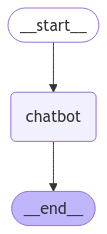

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Olá! Como posso ajudar você hoje?
Assistant: Olá, Matheus! Eu sou um assistente virtual e não tenho um nome próprio, mas você pode me chamar de Assistente. Como posso ajudar você hoje?
Assistant: Sua primeira mensagem foi: "Qual foi minha primeira mensagem?"
Assistant: Desculpe, mas não tenho a capacidade de acessar mensagens anteriores ou lembrar de interações passadas. Cada conversa é tratada de forma independente. Como posso ajudar você hoje?
Assistant: Hello! How can I assist you today?
Assistant: Hello! How can I assist you today?
Goodbye!


### Adding Tools

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

# test tavily serch
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making'},
 {'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': "In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state"}]

In [14]:
from langgraph.prebuilt import ToolNode

# Use tool node
tool_node = ToolNode(tools)

# add tool to llm
graph_builder = StateGraph(State)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# add nodes
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

In [16]:
from typing import Literal


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

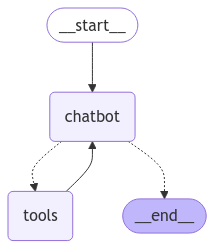

In [17]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [18]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: A data de hoje é 27 de outubro de 2023.
Assistant: 
Assistant: [{"url": "https://www.cnnbrasil.com.br/politica/com-mais-de-60-milhoes-de-votos-lula-e-o-presidente-mais-votado-da-historia/", "content": "Confira o histórico de votações em segundo turno:\n1989 – 2º turno\n2002 – 2º turno\n2006 – 2º turno\n2010 – 2º turno\n2014 – 2º turno\n2018 – 2º turno\n2022 – 2º turno\nBolsonaro – 58.205.269 – 43,2%\nFotos – veja imagens da comemoração de Lula e apoiadores\nApoiadores do presidente eleito Luiz Inácio Lula da Silva (PT), na avenida Paulita, após o resultado das eleições\nMovimentação de militantes do PT no vão central do Masp, na Avenida Paulista, na zona central de São Paulo, com a eleição de Luiz Inácio Lula da Silva como presidente do Brasil\nPronunciamento do presidente eleito Luiz Inácio Lula da Silva (PT), realizado na cidade de São Paulo\nPronunciamento do presidente eleito Luiz Inácio Lula da Silva (PT), realizado na cidade de São Paulo\nMovimentação de militantes do 

### Adding Memory

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

# Can be replaced by SqliteSaver or PostgresSaver
memory = MemorySaver()

In [20]:
from langgraph.prebuilt import tools_condition

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [25]:
graph = graph_builder.compile(checkpointer=memory)

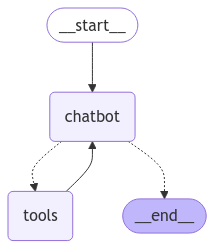

In [26]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [27]:
# Configuration to use thread_id to save messages
config = {"configurable": {"thread_id": "1"}}

#### Testing memory

In [28]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will! How can I assist you today?


In [29]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name, Will! How can I help you today?


In [30]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='0e4c8a71-d1f5-4d9f-8d42-39b8413feee9'), AIMessage(content='Hello Will! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 87, 'total_tokens': 98, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'stop', 'logprobs': None}, id='run-e0cc3c7f-f7e5-4abf-a19e-d99943fcc61c-0', usage_metadata={'input_tokens': 87, 'output_tokens': 11, 'total_tokens': 98, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='Remember my name?', additional_kwargs={}

In [31]:
snapshot.next

()